In [155]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor

In [3]:
df1=pd.read_csv("FAOSTAT_data - FAOSTAT_data_en_12-29-2024.csv")
df1.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure,NaN


In [4]:
item_code_counts = df1.groupby('Area')['Area Code (M49)'].nunique()
non_unique_items = item_code_counts[item_code_counts > 1]
if non_unique_items.empty:
    print("✅ Each item has a unique Area code.")
else:
    print("❌ The following items have multiple Area codes:")
    print(non_unique_items)

✅ Each item has a unique Area code.


In [5]:
df1.describe()

,Area Code (M49),Element Code,Year Code,Year,Value
count,224647.000000,224647.000000,224647.000000,224647.000000,2.181300e+05
mean,426.797932,5407.125285,2020.971658,2020.971658,8.984848e+05
std,254.501789,101.321826,1.403592,1.403592,1.201902e+07
min,4.000000,5111.000000,2019.000000,2019.000000,0.000000e+00
25%,203.000000,5312.000000,2020.000000,2020.000000,9.370000e+02
50%,414.000000,5412.000000,2021.000000,2021.000000,7.228200e+03
75%,643.000000,5510.000000,2022.000000,2022.000000,5.135000e+04
max,894.000000,5513.000000,2023.000000,2023.000000,7.825858e+08


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224647 entries, 0 to 224646
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Domain Code       224647 non-null  object 
 1   Domain            224647 non-null  object 
 2   Area Code (M49)   224647 non-null  int64  
 3   Area              224647 non-null  object 
 4   Element Code      224647 non-null  int64  
 5   Element           224647 non-null  object 
 6   Item Code (CPC)   224642 non-null  object 
 7   Item              224647 non-null  object 
 8   Year Code         224647 non-null  int64  
 9   Year              224647 non-null  int64  
 10  Unit              224645 non-null  object 
 11  Value             218130 non-null  float64
 12  Flag              224643 non-null  object 
 13  Flag Description  224634 non-null  object 
 14  Note              5098 non-null    object 
dtypes: float64(1), int64(4), object(10)
memory usage: 25.7+ MB


In [7]:
df1.shape

(224647, 15)

In [8]:
df1.columns

Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note'],
      dtype='object')

In [9]:
columns_unwanted=["Note","Flag Description","Flag","Area","Domain","Domain Code","Year Code"]
df1=df1.drop(columns=columns_unwanted)

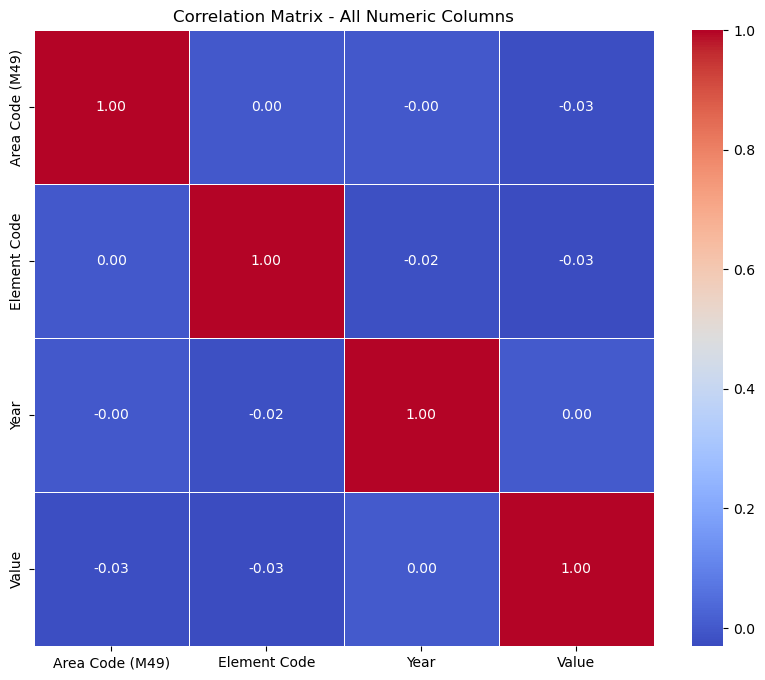

In [10]:

corr = df1.corr(numeric_only=True)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - All Numeric Columns')
plt.show()

In [11]:
df= df1.pivot_table(
    index=['Area Code (M49)','Element Code','Item Code (CPC)','Item','Year','Unit'],    
    columns='Element',                # Values in 'Element' become new columns
    values='Value',                   # Fill values from this column
    aggfunc='first'                   # In case of duplicates
).reset_index()

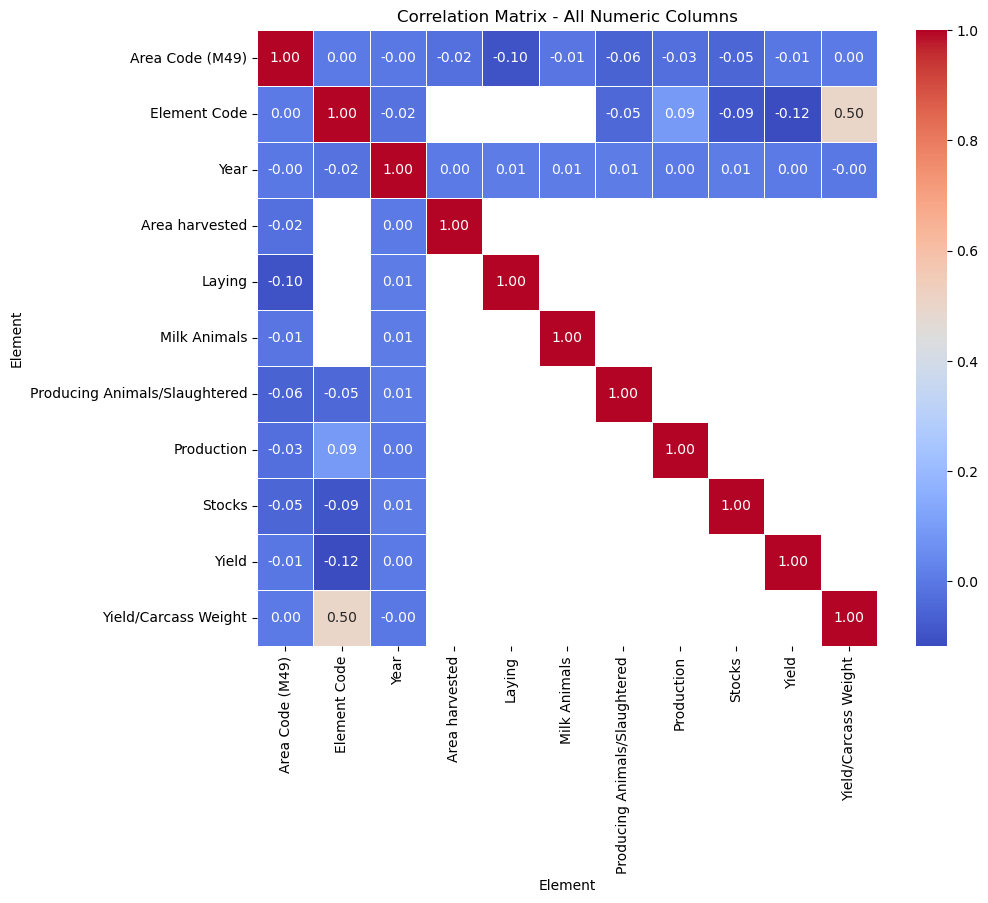

In [12]:

corr = df.corr(numeric_only=True)
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - All Numeric Columns')
plt.show()

In [13]:
df.head()

Element,Area Code (M49),Element Code,Item Code (CPC),Item,Year,Unit,Area harvested,Laying,Milk Animals,Producing Animals/Slaughtered,Production,Stocks,Yield,Yield/Carcass Weight
0,4,5111,2111,Cattle,2019,An,NaN,NaN,NaN,NaN,NaN,5223957.0,NaN,NaN
1,4,5111,2111,Cattle,2020,An,NaN,NaN,NaN,NaN,NaN,5296101.0,NaN,NaN
2,4,5111,2111,Cattle,2021,An,NaN,NaN,NaN,NaN,NaN,5366718.0,NaN,NaN
3,4,5111,2111,Cattle,2022,An,NaN,NaN,NaN,NaN,NaN,5498473.0,NaN,NaN
4,4,5111,2111,Cattle,2023,An,NaN,NaN,NaN,NaN,NaN,5597758.0,NaN,NaN


In [14]:
df.isnull().sum()

Element
Area Code (M49)                       0
Element Code                          0
Item Code (CPC)                       0
Item                                  0
Year                                  0
Unit                                  0
Area harvested                   170225
Laying                           217061
Milk Animals                     216016
Producing Animals/Slaughtered    200561
Production                       135107
Stocks                           209522
Yield                            166559
Yield/Carcass Weight             211817
dtype: int64

In [15]:
df.columns

Index(['Area Code (M49)', 'Element Code', 'Item Code (CPC)', 'Item', 'Year',
       'Unit', 'Area harvested', 'Laying', 'Milk Animals',
       'Producing Animals/Slaughtered', 'Production', 'Stocks', 'Yield',
       'Yield/Carcass Weight'],
      dtype='object', name='Element')

In [16]:
item_code_counts = df.groupby('Item')['Item Code (CPC)'].nunique()
non_unique_items = item_code_counts[item_code_counts > 1]
if non_unique_items.empty:
    print("✅ Each item has a unique item code.")
else:
    print("❌ The following items have multiple item codes:")
    print(non_unique_items)

❌ The following items have multiple item codes:
Item
Grapes    2
Name: Item Code (CPC), dtype: int64


In [17]:
df[df['Item'] == 'Grapes']['Item Code (CPC)'].unique()

array(['1330', '0'], dtype=object)

In [18]:
df.loc[df['Item'] == 'Grapes', 'Item Code (CPC)'] = 1330

In [19]:
item_code_counts = df.groupby('Item')['Item Code (CPC)'].nunique()
non_unique_items = item_code_counts[item_code_counts > 1]
if non_unique_items.empty:
    print("✅ Each item has a unique item code.")
else:
    print("❌ The following items have multiple item codes:")
    print(non_unique_items)

✅ Each item has a unique item code.


In [20]:
columns_to_remove=["Yield/Carcass Weight","Laying","Milk Animals","Producing Animals/Slaughtered","Item","Unit","Stocks"]
df=df.drop(columns=columns_to_remove)

In [21]:
df = df.fillna(df.median(numeric_only=True))
#df['Value'].fillna(df['Value'].median(),inplace=True)

In [22]:
df['Area Code (M49)'].unique()

array([  4,   8,  12,  24,  28,  31,  32,  36,  40,  44,  48,  50,  51,
        52,  56,  64,  68,  70,  72,  76,  84,  90,  96, 100, 104, 108,
       112, 116, 120, 124, 132, 140, 144, 148, 152, 156, 158, 159, 170,
       174, 178, 180, 184, 188, 191, 192, 196, 203, 204, 208, 212, 214,
       218, 222, 226, 231, 232, 233, 234, 242, 246, 250, 258, 262, 266,
       268, 270, 275, 276, 288, 296, 300, 308, 320, 324, 328, 332, 340,
       344, 348, 352, 356, 360, 364, 368, 372, 376, 380, 384, 388, 392,
       398, 400, 404, 408, 410, 414, 417, 418, 422, 426, 428, 430, 434,
       440, 442, 446, 450, 454, 458, 462, 466, 470, 478, 480, 484, 496,
       498, 499, 504, 508, 512, 516, 520, 524, 528, 540, 548, 554, 558,
       562, 566, 570, 578, 583, 584, 586, 591, 598, 600, 604, 608, 616,
       620, 624, 626, 630, 634, 642, 643, 646, 659, 662, 670, 678, 682,
       686, 688, 690, 694, 702, 703, 704, 705, 706, 710, 716, 724, 728,
       729, 740, 748, 752, 756, 760, 762, 764, 768, 772, 776, 78

In [23]:
df['Item Code (CPC)'].unique()

array(['2111', '2121.01', '2122', '2123', '2131', '2132', '2133', '2151',
       '111', '112', '113', '115', '118', '1221', '1229', '1253.02',
       '1290.9', '1315', '1323', '1329', 1330, '1341', '1342.01', '1343',
       '1345', '1346', '1349.2', '1355.9', '1359.9', '1371', '1375',
       '1376', '1379.9', '141', '1441', '1442', '1444', '1445', '1450',
       '1510', '1654', '1699', '1709.9', '1801', '1802', '1921.01', '231',
       '2211', '2291', '2292', '2293', '21111.01', '21115', '21116',
       '21117.01', '21151', '21155', '21156', '21159.02', '21512',
       '21514', '21515', '21519.02', '2951.01', '2953', '2954', '21121',
       '143', '1921.02', '21170.02', '21631.01', '2167', '2168',
       '21691.07', '21691.12', '22110.02', '22230.04', '22241.01',
       '22249.01', '22253', '22254', '2351f', '23540', '26110', '2910',
       '2941', '2944', '2112', '2140', '2152', '2196', '116', '117',
       '1212', '1213', '1214', '1215', '1231', '1232', '1233', '1234',
       '1235',

In [24]:
df['Element Code'].unique()

array([5111, 5112, 5312, 5313, 5318, 5320, 5321, 5410, 5412, 5413, 5417,
       5420, 5424, 5510, 5513, 5114], dtype=int64)

In [25]:
df['Year'].unique()

array([2019, 2020, 2021, 2022, 2023], dtype=int64)

In [26]:
df['Area harvested'].unique()

array([   3009., 2334000., 2668000., ...,    6177.,    6934.,    6388.])

In [27]:
df['Production'].unique()

array([  10923.67, 4890000.  , 5185000.  , ..., 1262821.  , 1273504.  ,
       1274929.  ])

In [28]:
df['Yield'].unique()

array([ 5216.2, 21163. , 21148. , ..., 13149. , 13140. , 13126. ])

In [29]:
df.columns

Index(['Area Code (M49)', 'Element Code', 'Item Code (CPC)', 'Year',
       'Area harvested', 'Production', 'Yield'],
      dtype='object', name='Element')

In [30]:
columns_to_check = ['Area harvested', 'Production', 'Yield']
df_clean = df.dropna(subset=columns_to_check)
z_scores = np.abs(stats.zscore(df_clean[columns_to_check], nan_policy='omit'))
threshold=3
print("size before removing outlier:", df.shape)
outlier_df=df[(z_scores>threshold).any(axis=1)]
outlier_df=df[(z_scores<=threshold).all(axis=1)]
print("size after removing outlier:", df.shape)

size before removing outlier: (218124, 7)
size after removing outlier: (218124, 7)


In [31]:
#df_numeric = df.select_dtypes(include='number').dropna()
#scaler = MinMaxScaler()
#df_s= pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

In [32]:
df['Item Code (CPC)'] = pd.to_numeric(df['Item Code (CPC)'], errors='coerce').astype('float')


In [33]:
df.dtypes

Element
Area Code (M49)      int64
Element Code         int64
Item Code (CPC)    float64
Year                 int64
Area harvested     float64
Production         float64
Yield              float64
dtype: object

In [43]:
df.duplicated().sum()

0

In [34]:
columns_to_scale = ['Area Code (M49)','Element Code','Item Code (CPC)','Year','Area harvested','Yield']
# Drop rows with NaNs in these columns (optional, but recommended)
df_clean = df.dropna(subset=columns_to_scale)
# Initialize the scaler
scaler = StandardScaler()
# Scale only the selected columns
scaled_data = scaler.fit_transform(df_clean[columns_to_scale])
# Put the scaled data back into a DataFrame
df_s = pd.DataFrame(scaled_data, columns=columns_to_scale, index=df_clean.index)
df = df_clean.copy()
df[columns_to_scale] = df_s


In [35]:
import pickle

scaler_filename = 'std_scaler.pkl'
with open(scaler_filename, 'wb') as f:
    pickle.dump(scaler, f)

In [36]:
df.tail()

Element,Area Code (M49),Element Code,Item Code (CPC),Year,Area harvested,Production,Yield
218119,1.841158,1.050663,-0.648426,-1.406762,-0.054913,1262821.0,-0.134174
218120,1.841158,1.050663,-0.648426,-0.694313,-0.054913,1273504.0,-0.134174
218121,1.841158,1.050663,-0.648426,0.018136,-0.054913,1274929.0,-0.134174
218122,1.841158,1.050663,-0.648426,0.730585,-0.054913,1275000.0,-0.134174
218123,1.841158,1.050663,-0.648426,1.443035,-0.054913,1275000.0,-0.134174


In [37]:
df.dtypes

Element
Area Code (M49)    float64
Element Code       float64
Item Code (CPC)    float64
Year               float64
Area harvested     float64
Production         float64
Yield              float64
dtype: object

In [38]:
x=df.drop('Production',axis=1)
y=np.log1p(df['Production'])
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=0.2, random_state=42)
print(f"x_train {x_train.shape}")
print(f"x_test {x_test.shape}")

x_train (174101, 6)
x_test (43526, 6)


In [39]:
print(np.log1p(y_train).shape)

(174101,)


In [40]:
models=[
    ('CatBoost', CatBoostRegressor(verbose=0)),
    ('Random Forest', RandomForestRegressor()),
    ('Linear Regression', LinearRegression()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('KNN', KNeighborsRegressor())
]

In [41]:
for name,model in models:
    print(name)
    print()
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    print("Mean squared Error", mean_squared_error(y_test,y_pred))
    print("Mean absolute Error", mean_absolute_error(y_test,y_pred))
    print("R2 score", r2_score(y_test,y_pred))
    print("\n")

CatBoost

Mean squared Error 2.2748875226222918
Mean absolute Error 0.7297869036899952
R2 score 0.5793171021236705


Random Forest

Mean squared Error 0.2516023002573129
Mean absolute Error 0.18210532581247166
R2 score 0.9534725195280916


Linear Regression

Mean squared Error 5.322806780189857
Mean absolute Error 1.2091021532886665
R2 score 0.015681540797729876


Decision Tree

Mean squared Error 0.16588360645278188
Mean absolute Error 0.07680564382081356
R2 score 0.9693240234610406


KNN

Mean squared Error 3.582980397125543
Mean absolute Error 0.8808373333754914
R2 score 0.33741841673149053




In [88]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
x_train = df[['Area Code (M49)', 'Element Code', 'Item Code (CPC)', 'Year', 'Area harvested', 'Yield']]
y_train = df['Production']
model.fit(x_train, y_train)

DecisionTreeRegressor()

In [89]:
import pickle
from sklearn.ensemble import RandomForestClassifier

# Example model
tree_model = DecisionTreeRegressor()
# Assume X_train and y_train are your training data
tree_model.fit(x_train, y_train)

# Save the model to a file
with open('tree_model.pkl', 'wb') as file:
    pickle.dump(tree_model, file)


In [85]:
df.head()

Element,Area Code (M49),Element Code,Item Code (CPC),Year,Area harvested,Production,Yield
0,-1.659551,-2.928301,-0.41601,-1.406762,-0.054913,-0.049439,-0.134174
1,-1.659551,-2.928301,-0.41601,-0.694313,-0.054913,-0.049439,-0.134174
2,-1.659551,-2.928301,-0.41601,0.018136,-0.054913,-0.049439,-0.134174
3,-1.659551,-2.928301,-0.41601,0.730585,-0.054913,-0.049439,-0.134174
4,-1.659551,-2.928301,-0.41601,1.443035,-0.054913,-0.049439,-0.134174


In [86]:
df.tail()

Element,Area Code (M49),Element Code,Item Code (CPC),Year,Area harvested,Production,Yield
218119,1.841158,1.050663,-0.648426,-1.406762,-0.054913,0.119419,-0.134174
218120,1.841158,1.050663,-0.648426,-0.694313,-0.054913,0.120860,-0.134174
218121,1.841158,1.050663,-0.648426,0.018136,-0.054913,0.121052,-0.134174
218122,1.841158,1.050663,-0.648426,0.730585,-0.054913,0.121062,-0.134174
218123,1.841158,1.050663,-0.648426,1.443035,-0.054913,0.121062,-0.134174


In [87]:
input_data = [[894,5513,231,2023,171284.52,13298.88]] 
y_pred_l = model_X.predict(input_data)
y_pred_l

NameError: name 'model_X' is not defined

In [ ]:
input_data = [[4,5111,2111,2020,171284.52,13298.88]]
y_pred_l = model_X.predict(input_data)
y_pred_l

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([-0.03989331])

In [ ]:
df.shape

(218124, 7)

In [ ]:
x.shape

(217627, 6)

In [ ]:
y.shape

(217627,)